# GS Earnings Calls Analysis

In [1351]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from datetime import datetime


%matplotlib inline

## Import and Clean Data

In [1525]:
filename = 'earningscalls/earningscalls/spiders/jpm_transcript_output.csv'

with open(filename) as f:
    content = f.readlines()

In [1526]:
import ast
l = []
for item in content:
    try:
        l.append(ast.literal_eval(item))
    except:
        continue

for n, i in enumerate(l):
    if type(i) != dict:
        l[n] = dict(i[0])

In [1527]:
import re

for i in l:
    for k, v in i.items():
        m = re.search('(Q[1-4])\s([0-9]*)', k)
        if m:
            found = m.group(2) + m.group(1)
            i[found] = i.pop(k)

In [1528]:
quarters = []
for i in l:
    for k, v in i.items():
        quarters.append(k)

In [1529]:
def remove_header_footer(lst):
    for n, i in enumerate(lst):
        if '><strong>Operator' in i:
            break
    lst = lst[n:]
    for n, i in enumerate(lst):
        if '<strong>Copyright policy' in i:
            break
    lst = lst[:n]
    return lst
                

In [1530]:
# for n, i in enumerate(l[0]['2013Q4']):
#     print i

In [1531]:
# for n, i in enumerate(l):
#     print n, i
#     break

In [1532]:
import lxml.html
from collections import defaultdict
from fuzzywuzzy import fuzz

def create_dict(lst):
    d = defaultdict(list)
    k_list = []
    for n, i in enumerate(lst):
        if '><strong>' in i:
            try:
                key_html = lxml.html.fromstring(i)
                value_html = lxml.html.fromstring(lst[n+1])
            except:
                continue
            
            key = key_html.text_content()
            try:
                key = key.split()[0] + key.split()[1]
            except:
                key = key.split()[0]
            if key not in k_list:
                k_list.append(key)
            # fuzzy matching to resolve typos for keys
            for n, existing_key in enumerate(k_list):
                ratio = fuzz.ratio(existing_key, key)
                if ratio < 100 and ratio > 69:
                    key = existing_key
                    k_list.pop(n)
            value = value_html.text_content()
            #remove unicode characters 
            value = value.decode('unicode_escape').encode('ascii','ignore')

            d[key].append(value)
    return d
    

### Split Management Discussion and Q&A

In [1533]:
new_EC_dict = {}

for d in l:
    new_EC_dict[d.keys()[0]] = d.values()

In [1534]:
# new_EC_dict['2014Q4']

In [1535]:
df_EC = pd.DataFrame(new_EC_dict)

In [1536]:
for k, v in new_EC_dict.items():
    new_EC_dict[k] = remove_header_footer(v[0])


In [1537]:
def split_discussion_q_and_a(lst):
    discussion_l = []
    q_and_a_l = []
    for n, i in enumerate(lst):
        if 'id="question-answer-session"' in i:
            break
        discussion_l.append(i)
        q_and_a_l = lst[n:] 
    return discussion_l, q_and_a_l

In [1538]:
q_and_a_dict = {}
discussion_dict = {}
for k, v in new_EC_dict.items():
    discussion_dict[k] = split_discussion_q_and_a(v)[0]
    q_and_a_dict[k] = split_discussion_q_and_a(v)[1]

In [1539]:
for k, v in discussion_dict.items():
    lines = []
    for line in v:
        line = lxml.html.fromstring(line).text_content()
        line = line.decode('unicode_escape').encode('ascii','ignore')
        lines.append(line)
    discussion_dict[k] = lines

In [1540]:
for k, v in q_and_a_dict.items():
    lines = []
    for line in v:
        line = lxml.html.fromstring(line).text_content()
        line = line.decode('unicode_escape').encode('ascii','ignore')
        lines.append(line)
    q_and_a_dict[k] = lines

In [1541]:
q_and_a_dict['2013Q3']

['And with that, Mike and I are happy to take any questions.', 'Question-and-Answer Session', 'Operator', '[Operator instructions.] And your first question comes from the line of John McDonald with Sanford Bernstein.', 'John McDonald - Sanford Bernstein ', 'I was wondering how youre feeling about some of the 2015 financial targets. If we look at the ROA target of 90 to 110 basis points in 2015, we look at this quarter at [59] basis points year to date, around 80, what do you see as the key driver to getting toward the 2015 goal?', 'John Gerspach ', 'As weve talked about, reducing the losses in Citi Holdings is certainly one of the key goals that we see driving us toward the goal of generating ROA of between 90 and 110 basis points in 2015. And wed also look for some modest amount of net income improvement coming out of Citicorp as well.', 'John McDonald - Sanford Bernstein ', "On the Citicorp side, I guess the efficiency goal is part of those 2015 targets around mid-50s, I'd just call 

### Speaker Dictionary Creation

In [1542]:
dict_l = []
quarter_l = []
dates = []
for n, i in enumerate(l):
    try:
        key, value = i.items()[0]
        quarter_l.append(key)
        date = value[2]
        dates.append(date)
        lst = remove_header_footer(l[n][key])
        d = create_dict(lst)
        dict_l.append((key, d))
    except:
        print(n, key)
        continue

12 2013Q3
19 2015Q3
23 Q2
25 Q3
27 Q4
29 2014Q1
30 2014Q2
31 2014Q3


In [1543]:
df_EC_speakers = pd.DataFrame(dict_l)
df_EC_speakers

,0,1
0,2010Q4,{u'EdwardNajarian': [u'Maybe just two quick on...
1,2011Q1,{u'CaroleBerger': [u'Bank of America took a ch...
2,2011Q2,"{u'JohnGerspach': [u'Thank you, Vikram, and go..."
3,2011Q3,"{u'JohnE.': [u'John, just following up on Glen..."
4,2011Q4,"{u'JohnE.': [u'John, could you give us a littl..."
5,2012Q1,{u'JohnE.': [u'One follow-up to Glenn's questi...
6,2012Q1,{u'DavidKnutson': [u'Got a couple of questions...
7,2012Q2,"{u'JohnE.': [u'Yes, hi, John. I was wondering ..."
8,2012Q3,"{u'MikeMayo': [u'Hi, how much of the $53 billi..."
9,2012Q4,"{u'Throughoutthis': [u'Year over year, about h..."


In [1544]:
from dateutil.parser import *

def clean_dates(dates):
    for n, date in enumerate(dates):
        date = lxml.html.fromstring(date).text_content().split()
        datetime_object = parse(' '.join(date[:3]))
        dates[n] = datetime_object
        

In [1545]:
clean_dates(dates)
# zip(dates, quarters)

In [1546]:
len(dict_l)

28

In [1547]:
# remove Operator lines
def removekey(d, key):
    r = dict(d)
    del r[key]
    return r

In [1548]:
for n, d in enumerate(dict_l):
    d = removekey(d, 'Operator')
    dict_l[n] = d

ValueError: dictionary update sequence element #0 has length 6; 2 is required

In [1549]:
dict_l[0]

('2010Q4', defaultdict(<type 'list'>, {'EdwardNajarian': ['Maybe just two quick ones. Would you be willing to disclose some approximation of what your Bassel III based Tier 1 Common ratio is today? And then how would you advise us to think about the pace of shrink of Citi Holdings over the next 12 months?', 'And then, obviously, as we get to the end of this quarter, you get some sense from the regulators, we think, in terms of what your discussions with regulators are, what they come back to you with in terms of your capital planning. Do you expect to give us more detail on capital planning and on your Bassel III base Tier 1 Common ratio when you report first quarter earnings and will be enabled at that time?'], 'JohnGerspach': ['Thank you, Vikram, and good morning, everyone. Starting on Slide 2. On a full year basis, Citigroup reported revenues of nearly $87 billion for 2010. Operating expenses totaled $47.4 billion. Credit costs were $26 billion, down 50% from prior year levels on a 

In [1550]:
# for n, d in enumerate(dict_l):
#     try:
#         print(d)
#     except:
#         continue

In [1551]:
# speakers = []
# for n, d in enumerate(dict_l):
#     for k, v in d.items():
#         speakers.append(k)
# set(speakers)


## Sentiment Analysis

In [1629]:
# get eps surprises

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time

import os

In [1553]:
chromedriver = "/Applications/chromedriver"
os.environ["webdriver.chrome.driver"] = chromedriver

PROXY = 'http://us-ny.proxymesh.com:31280'

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--proxy-server=%s' % PROXY)

driver = webdriver.Chrome(chromedriver, chrome_options=chrome_options)
# chrome.get("http://whatismyipaddress.com")
driver.get("https://www.streetinsider.com/ec_earnings.php?q=c")

# driver.implicitly_wait(5) # seconds


cookies = driver.get_cookies()

button=driver.find_element_by_xpath('//*[@id="expandbtn"]')
button.click()

In [1554]:
surprise_quarters = []
consensus = []
surprise = []
for j in range(25):
    try:
        q = driver.find_element_by_xpath('//*[@id="content"]/table[1]/tbody/tr['+ str(j) + ']/td[3]')
        c = driver.find_element_by_xpath('//*[@id="content"]/table[1]/tbody/tr['+ str(j) + ']/td[5]')
        s = driver.find_element_by_xpath('//*[@id="content"]/table[1]/tbody/tr['+ str(j) + ']/td[6]') 
        surprise_quarters.append(q.text)
        consensus.append(c.text)
        surprise.append(s.text)
    except:
        continue
        
for j in range(25):
    try:
        q = driver.find_element_by_xpath('//*[@id="history_extra"]/tbody/tr[' + str(j) + ']/td[3]')
        c = driver.find_element_by_xpath('//*[@id="history_extra"]/tbody/tr[' + str(j) + ']/td[5]')
        s = driver.find_element_by_xpath('//*[@id="history_extra"]/tbody/tr[' + str(j) + ']/td[6]')
        
        surprise_quarters.append(q.text)
        consensus.append(c.text)
        surprise.append(s.text)
    except:
        continue

In [1630]:
df_surprise = pd.DataFrame()
df_surprise['Quarters'] = pd.Series(surprise_quarters)
df_surprise['Surprise_Consensus_EPS'] = pd.Series(consensus)
df_surprise['Surprise_EPS'] = pd.Series(surprise)

In [1631]:
# fix quarter format

def fix_eps_quarters(s):
    q = s[:2]
    year = s[2:]
    return '20' + year + q

# fix EPS to numerice

def fix_eps_to_numeric(s):
    s = s.replace("$", "")
    return s

In [1632]:
df_surprise['Quarters'] = df_surprise.Quarters.apply(fix_eps_quarters)

In [1633]:
df_surprise['Surprise_Consensus_EPS'] = pd.to_numeric(df_surprise.Surprise_Consensus_EPS.apply(fix_eps_to_numeric))
df_surprise['Surprise_EPS'] =  pd.to_numeric(df_surprise.Surprise_EPS.apply(fix_eps_to_numeric))

In [1634]:
df_surprise.sort_values(by='Quarters').head()

,Quarters,Surprise_Consensus_EPS,Surprise_EPS
25,2010Q3,0.06,0.02
24,2010Q4,0.08,-0.04
23,2011Q1,0.09,0.01
22,2011Q2,0.97,0.12
21,2011Q3,0.82,0.02


In [1635]:
transcripts[0][0]

'2010Q4'

In [1636]:
import nltk
from textblob import TextBlob

transcripts = dict_l
# transcripts[0]
for n, i in enumerate(dict_l):
#     print(len(dict_l[n]))
    for k in dict_l[n]:
        print(k)
    break

2010Q4
defaultdict(<type 'list'>, {'EdwardNajarian': ['Maybe just two quick ones. Would you be willing to disclose some approximation of what your Bassel III based Tier 1 Common ratio is today? And then how would you advise us to think about the pace of shrink of Citi Holdings over the next 12 months?', 'And then, obviously, as we get to the end of this quarter, you get some sense from the regulators, we think, in terms of what your discussions with regulators are, what they come back to you with in terms of your capital planning. Do you expect to give us more detail on capital planning and on your Bassel III base Tier 1 Common ratio when you report first quarter earnings and will be enabled at that time?'], 'JohnGerspach': ['Thank you, Vikram, and good morning, everyone. Starting on Slide 2. On a full year basis, Citigroup reported revenues of nearly $87 billion for 2010. Operating expenses totaled $47.4 billion. Credit costs were $26 billion, down 50% from prior year levels on a comp

In [1637]:
sentiments = []
quarters = []
for n, i in enumerate(dict_l):
    doc_list = [item for k[1] in dict_l[n] for item in i]
    quarters.append(dict_l[n][0])

    EC_text = ' '.join(str(e) for e in doc_list)
    EC = TextBlob(EC_text)

#     sentiment = [i.sentiment.polarity for i in EC.sentences]
    sentiment = EC.sentiment.polarity

#     total_sentiment = 0.0
#     for i in sentiment:
#         total_sentiment = total_sentiment + i
    sentiments.append(sentiment)
pairs = zip(quarters, dates, sentiments)
pairs.sort()
pairs

[('2010Q4', datetime.datetime(2011, 1, 18, 0, 0), 0.08104979825428205), ('2011Q1', datetime.datetime(2011, 4, 18, 0, 0), 0.08820964035002177), ('2011Q2', datetime.datetime(2011, 7, 15, 0, 0), 0.10340950401324525), ('2011Q3', datetime.datetime(2011, 10, 17, 0, 0), 0.1018829256127912), ('2011Q4', datetime.datetime(2012, 1, 17, 0, 0), 0.08398586434614856), ('2012Q1', datetime.datetime(2012, 4, 16, 0, 0), 0.13754457406999757), ('2012Q1', datetime.datetime(2012, 4, 25, 0, 0), 0.11059819986265079), ('2012Q2', datetime.datetime(2012, 7, 16, 0, 0), 0.1361032183426505), ('2012Q3', datetime.datetime(2012, 10, 15, 0, 0), 0.09472592962592981), ('2012Q4', datetime.datetime(2013, 1, 17, 0, 0), 0.05982335300825357), ('2013Q1', datetime.datetime(2013, 4, 15, 0, 0), 0.06329164074118218), ('2013Q2', datetime.datetime(2013, 7, 15, 0, 0), 0.08479710248062622), ('2013Q3', datetime.datetime(2013, 10, 15, 0, 0), 0.09646293190936042), ('2013Q4', datetime.datetime(2014, 1, 17, 0, 0), 0.11805490167559053), ('20

In [1638]:
unzipped_pairs = zip(*pairs)

In [1639]:
df_sentiment = pd.DataFrame()
df_sentiment['Quarters'] = pd.Series(unzipped_pairs[0])
df_sentiment['EC_Dates'] = pd.Series(unzipped_pairs[1])
df_sentiment['EC_sentiment'] = pd.Series(unzipped_pairs[2])

In [1640]:
df_surprise

,Quarters,Surprise_Consensus_EPS,Surprise_EPS
0,2016Q4,1.12,0.02
1,2016Q3,1.16,0.08
2,2016Q2,1.10,0.14
3,2016Q1,1.03,0.07
4,2015Q4,1.05,0.01
5,2015Q3,1.27,0.04
6,2015Q2,1.34,0.11
7,2015Q1,1.39,0.13
8,2014Q4,0.09,-0.03
9,2014Q3,1.12,0.03


In [1641]:
df_merged = pd.merge(df_sentiment, df_surprise, how='left', on='Quarters')

In [1642]:
import csv
filename = 'Cdailyprice2010_2016.csv'

Dates = []
Close = []
with open(filename) as f:
    content = csv.reader(f)
    for row in content:
        Dates.append(row[0])
        Close.append(row[4])
        

In [1643]:
Dates = Dates[1:]
Close = Close[1:]
df = pd.read_csv('Cdailyprice2010_2016.csv')

In [1644]:
df_merged.head()

,Quarters,EC_Dates,EC_sentiment,Surprise_Consensus_EPS,Surprise_EPS
0,2010Q4,2011-01-18,0.081050,0.08,-0.04
1,2011Q1,2011-04-18,0.088210,0.09,0.01
2,2011Q2,2011-07-15,0.103410,0.97,0.12
3,2011Q3,2011-10-17,0.101883,0.82,0.02
4,2011Q4,2012-01-17,0.083986,0.48,-0.10


In [1645]:
# df2 = pd.DataFrame([['2013Q3', '2013-10-17', 0, 0, 0], ['2014Q2', '2014-07-15', 0, 0, 0]], columns=['Quarters', \
#                             'EC_Dates', 'EC_sentiment', 'Surprise_Consensus_EPS', 'Surprise_EPS'])

In [1646]:
# df_merged = df_merged.append(df2, ignore_index=True)
df_merged["EC_Dates"] = pd.to_datetime(df_merged.EC_Dates, errors='coerce')
df_merged = df_merged.sort_values(by='Quarters')

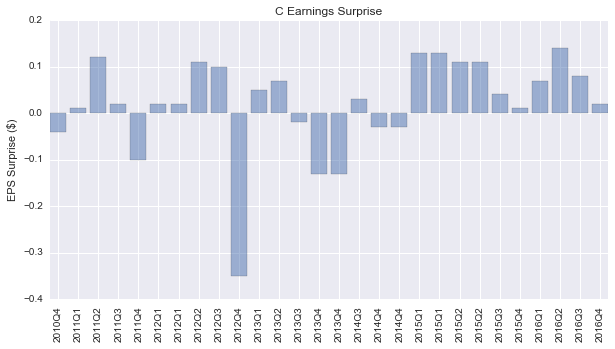

In [1647]:
# df_merged.Surprise_EPS.plot(kind='bar')

objects = df_merged.Quarters

quarters = np.arange(df_merged.Quarters.shape[0])
surprises = df_merged.Surprise_EPS

plt.figure(figsize=(10,5))
plt.bar(quarters, surprises, alpha=0.5, align='center')
plt.xticks(quarters, objects, rotation='vertical')
plt.ylabel('EPS Surprise ($)')
plt.title('C Earnings Surprise')
plt.autoscale()
plt.show()

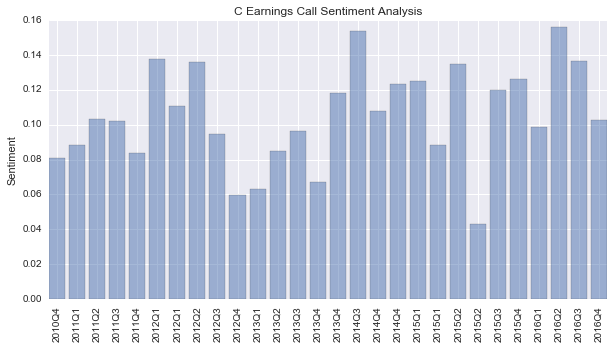

In [1648]:
objects = df_merged.Quarters

quarters = np.arange(df_merged.Quarters.shape[0])
sentiments = df_merged.EC_sentiment

plt.figure(figsize=(10,5))
plt.bar(quarters, sentiments, alpha=0.5, align='center')
plt.xticks(quarters, objects, rotation='vertical')
plt.ylabel('Sentiment')
plt.title('C Earnings Call Sentiment Analysis')
plt.autoscale()
plt.show()

In [1649]:
df = df.sort_values(['Date'])

In [1650]:
df.Date = pd.to_datetime(df['Date'])
EC_dates_mask = df_merged['EC_Dates']

In [1651]:
EC_dates_mask_index = []
for n, i in enumerate(df.Date):
    if i in list(EC_dates_mask):
        EC_dates_mask_index.append(n)

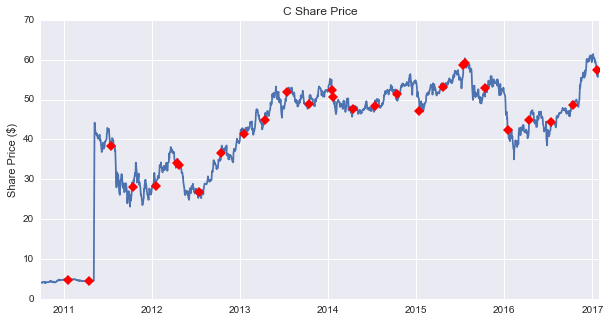

In [1652]:
markers_on = EC_dates_mask_index
plt.figure(figsize=(10,5))
plt.ylabel('Share Price ($)')
plt.title('C Share Price')
plt.plot(df.Date, df.Close, '-')
plt.plot(df.Date, df.Close, 'rD', markevery=markers_on)


# plt.autoscale()

In [1653]:
df_scatter = pd.DataFrame()
df_scatter = pd.merge(df_merged, df, left_on='EC_Dates', right_on='Date')
df_scatter['Day_percent_change'] = (df_scatter.Close - df_scatter.Open)/df_scatter.Open * 100
# df_scatter = df_scatter.drop(12)
# df_scatter = df_scatter.drop(15)
df_scatter.head()

,Quarters,EC_Dates,EC_sentiment,Surprise_Consensus_EPS,Surprise_EPS,Date,Open,High,Low,Close,Volume,Adj Close,Day_percent_change
0,2010Q4,2011-01-18,0.081050,0.08,-0.04,2011-01-18,4.930000,4.950000,4.780000,4.800000,180960500,47.108171,-2.636917
1,2011Q1,2011-04-18,0.088210,0.09,0.01,2011-04-18,4.420000,4.520000,4.350000,4.420000,79085300,43.378775,0.000000
2,2011Q2,2011-07-15,0.103410,0.97,0.12,2011-07-15,40.139999,40.389999,38.119999,38.380001,69517800,37.676211,-4.384649
3,2011Q3,2011-10-17,0.101883,0.82,0.02,2011-10-17,28.820000,29.490000,27.879999,27.930000,82340000,27.425003,-3.088133
4,2011Q4,2012-01-17,0.083986,0.48,-0.10,2012-01-17,29.180000,29.969999,28.160000,28.219999,116154600,27.719050,-3.289928


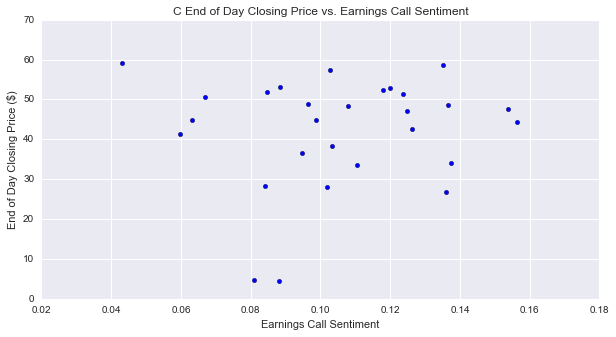

In [1654]:
plt.figure(figsize=(10,5))
plt.ylabel('End of Day Closing Price ($)')
plt.xlabel('Earnings Call Sentiment')
plt.title('C End of Day Closing Price vs. Earnings Call Sentiment')
plt.scatter(df_scatter.EC_sentiment, df_scatter.Close)
# plt.scatter(df_scatter.EC_sentiment, df_scatter.Surprise_EPS)

In [1655]:
# for word, count in sorted(EC.word_counts.items(),key=lambda x: x[1], reverse=True):
#     print("%15s %i" % (word,count))

In [1656]:
from nltk.util import ngrams

from collections import defaultdict
from operator import itemgetter

from nltk.corpus import stopwords
stop = stopwords.words('english')
stop += ['.', ',', '(', ')', "'", '"']

counter = defaultdict(int)

n = 2
# for doc in documents:
words = TextBlob(EC_text).words
words = [w for w in words if w not in stop]
bigrams = ngrams(words,n)
for bigram in bigrams:
    counter[bigram] += 1
            
for bigram, count in sorted(counter.items(), key = itemgetter(1), reverse=True)[:30]:
    phrase = " ".join(bigram)
#     print('%20s %i' % (phrase, count))

## Topic Modelling

In [1657]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

from __future__ import print_function

In [1658]:
t_dict_corpus = zip(*dict_l)[1]
l_dict_corpus = list(t_dict_corpus)


In [1659]:
# discussion_corpus = []
# for k,v in discussion_dict.items():
#     for item in v:
#         discussion_corpus.append((k, item))
        
# q_and_a_corpus = []
# for k,v in q_and_a_dict.items():
#     for item in v:
#         q_and_a_corpus.append((k, item))
    
    

In [1660]:
# discussion_corpus = zip(*discussion_corpus)[1]
# q_and_a_corpus = zip(*q_and_a_corpus)[1]

In [1661]:
# discussion_corpus[2]
# q_and_a_corpus[4]

In [1662]:
corpus = []
for n, i in enumerate(l_dict_corpus):
    doc_list = [item for k,v in l_dict_corpus[n].items() for item in v]
    EC_text = ' '.join(str(e) for e in doc_list)
    corpus.append(EC_text)

In [1663]:
# len(corpus)

In [1664]:
# corpus

In [1665]:
n_samples = 2000
n_features = 1000
n_topics = 7
n_top_words = 20


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


In [1666]:
# my_stops

In [1667]:
my_stops = stopwords.words('english')
my_stops = my_stops + ['ahead', 'youre', 'weve', 'yeah', 'hi', 'hey', 'im', 'youve', 'theres', 'indiscernible',\
                      'thats', 'theyre', 'youll', 'david', 'roger', 'freeman', 'please', 'harvey', 'schwartz',\
                      'fiona', 'swaffield', 'operator', 'glenn', 'officer', 'executive', 'vice', 'president',\
                      'mitchell', 'michael', 'mayo', 'securities', 'agricole', 'morning', 'mike', 'steven',\
                      'christian', 'devin', 'guy', 'marty', 'betsy', 'jim', 'chubak', 'nomura', 'graseck',\
                      'morgan', 'stanley', 'kian', 'ph', 'bruce']

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=2, stop_words=my_stops, max_features=n_features, ngram_range=(1,2))
cv_vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words=my_stops, max_features=n_features)
tfidf_vectorizer 
cv_vectorizer

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.9, max_features=1000, min_df=2,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'w... 'marty', 'betsy', 'jim', 'chubak', 'nomura', 'graseck', 'morgan', 'stanley', 'kian', 'ph', 'bruce'],
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [1668]:
tfidf = tfidf_vectorizer.fit_transform(corpus)
cv = cv_vectorizer.fit_transform(corpus)

In [1669]:
nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5)

topic_vectors = nmf.fit_transform(cv)

In [1670]:
print("\nTopics in NMF model:")
# tfidf_feature_names = tfidf_vectorizer.get_feature_names()
cv_feature_names = cv_vectorizer.get_feature_names()
# print_top_words(nmf, tfidf_feature_names, n_top_words)
print_top_words(nmf, cv_feature_names, n_top_words)


Topics in NMF model:
Topic #0:
expenses expense investment operating banking basel citicorp asset iii trading positive revenue nim fx cards legal certainly 2012 decline leverage
Topic #1:
debt tlac eric dont rules thanks gsib oil dollar issue sheet seen senior issuance range change fed helpful stress prices
Topic #2:
mexico costco cards investment new dta investments card ccar leverage operating certainly sheet thanks return seen icg third great energy
Topic #3:
dont mortgage operating expense basel certainly ratio tax sales iii seen dta reserve anything korea expenses months better mortgages sale
Topic #4:
expenses thanks repositioning certainly trading 2015 better 2014 expense revenue efficiency big targets ccar dta related progress legal operational actions
Topic #5:
thanks ratio efficiency revenue debt nim problem core cost asset weighted asia card great energy target onemain dont citicorp sales
Topic #6:
debt deposits tier basel eric trups entities corporate europe moody repo fix

In [1671]:
np.set_printoptions(precision=2)

sort_topicvectors_quarters = []

for i in zip(list(df_EC_speakers[0]), topic_vectors):
    sort_topicvectors_quarters.append(i)

# for i in sorted(sort_topicvectors_quarters):
#     print(i)

# df_nmf = pd.DataFrame(topic_vectors)
# df_nmf

In [1674]:
sort_topicvectors_quarters.sort()
quarters, topics = zip(*sort_topicvectors_quarters)

max_topics = []
for i in topics:
    max_topic = np.argmax(i)
    max_topics.append(max_topic)
    
plt.figure(figsize=(10,5))
plt.bar(range(len(quarters)), max_topics, align='center')
plt.xticks(range(len(quarters)), quarters, rotation='vertical')
plt.ylabel('Topic Category')
plt.xlabel('Quarters')
plt.title('Topic Modelling by Quarter')
plt.autoscale()
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [1673]:
topic_vectors.shape

(28, 7)

In [1099]:
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(tfidf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_jobs=1, n_topics=20, perp_tol=0.1, random_state=0,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [1100]:
print("\nTopics in LDA model:")
tf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model:
Topic #0:
100 fair 300 mike billion increase could may know operator offering underwriting return also think seen high harvey largely expenses
Topic #1:
clients term shareholders long long term capital continue franchise client firm environment returns businesses global value believe people operating client franchise commitment
Topic #2:
client quarter activity year credit market client activity economic revenues compensation global net levels ficc first environment billion net revenues benefits lower
Topic #3:
welcome morning good good morning investor relations relations quarter earnings dane holmes investor relations goldman sachs welcome dane holmes morning dane earnings conference conference holmes head head investor conference call head
Topic #4:
thank questions happy take questions listening listening today thank listening like thank take answer answer questions happy answer dialing happy take today like today happy thanks results take give
Topic #5:
dane h

In [1101]:
topic_vectors = lda.fit_transform(tfidf)

In [1102]:
np.set_printoptions(precision=2)

sort_topicvectors_quarters = []

for i in zip(list(df_EC_speakers[0]), topic_vectors):
    sort_topicvectors_quarters.append(i)

for i in sorted(sort_topicvectors_quarters):
    print(i)

('2010Q3', array([ 0.01,  0.01,  0.5 ,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.36,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01]))
('2010Q4', array([ 0.01,  0.01,  0.8 ,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.07,
        0.01,  0.01]))
('2011Q1', array([ 0.01,  0.01,  0.33,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.53,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01]))
('2011Q2', array([ 0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.86,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01]))
('2011Q3', array([ 0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.86]))
('2011Q4', array([ 0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.01, 